In [1]:
from __future__ import print_function

import os, sys
import numpy as np
import scipy as sp
from numpy import sin, cos, exp, log, log10, pi, absolute, power, sqrt
from numpy.polynomial import chebyshev as T
from numpy.polynomial import hermite_e as H
from scipy.integrate import quad
from scipy.misc import factorial
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from spectral_tools import Decompose, ModalD, NodalD, Vandermonde
from edgedetect import ChebEdgeIII, ConfigurePlots, Enhance, LocateEdges, MinMod

# N = 32 behaviour testing

In [2]:
N = 32
x = np.linspace(-1.0, 1.0, 2001)
c2s, s2c = Vandermonde(N)
modalD = ModalD(c2s)

In [3]:
step_loc1 = -0.4
width1 = 1.0
chi1 = lambda x: 1.0 if (x>=step_loc1 and x<=(step_loc1+width1)) else 0
a_n1 = Decompose(chi1, c2s)
I_N1 = T.chebval(x, a_n1)
c_j1 = LocateEdges(a_n1, x, modalD)
chi1_x = np.frompyfunc(chi1, 1, 1)(x)

step_loc2 = 0.5
width2 = 1.0
chi2 = lambda x: 1.0 if (x>=step_loc2 and x<=(step_loc2+width2)) else 0
a_n2 = Decompose(chi2, c2s)
I_N2 = T.chebval(x, a_n2)
c_j2 = LocateEdges(a_n2, x, modalD)
chi2_x = np.frompyfunc(chi2, 1, 1)(x)

In [4]:
def MollifyQuad(theta, c_j, a_n, x):
    
    N = a_n.shape[0]-1
    offset = x
    convolution = np.empty(len(x))
    
    I_N = lambda y: T.chebval(y, a_n)
    I_Nf = lambda y: I_N(y) if -1 <= y <= 1 else 0
    
    for idx, off_x in enumerate(offset):
        c_jx = c_j - off_x
        dx = lambda y: sqrt(theta*N*min(abs(y-c) for c in c_jx))
        var = lambda y: N/(2*theta*dx(y))
        p_N = lambda y: (theta**2)*dx(y)*N
        j_max = int(np.amax(np.frompyfunc(p_N,1,1)(x)))
        h_j = np.zeros(2*(j_max+1))
    
        for j in range(j_max+1):
            h_j[2*j] = ((-1)**j)/((4**j)*factorial(j))
    
        hermite = lambda y: H.hermeval(sqrt(var(y))*y, h_j)
        expon = lambda y: (1./sqrt(theta*N*dx(y)))*exp(-var(y)*(y**2))
        phi = lambda y: hermite(y)*expon(y)
        phif = lambda y: phi(y-off_x)
        norm = quad(phi, -1.0, 1.0)[0]
        
        convfunc = lambda y: (phif(y) * I_Nf(y))
        convolution[idx] = (1/norm)*quad(convfunc, -1.0, 1.0)[0]
    
    return convolution

In [5]:
ConfigurePlots()
theta = 1./4.
mollified1 = MollifyQuad(theta, c_j1, a_n1, x)
mollified2 = MollifyQuad(theta, c_j2, a_n2, x)

In [6]:
err1 = absolute(mollified1 - chi1_x)
err2 = absolute(mollified2 - chi2_x)

(<matplotlib.legend.Legend at 0x115940d10>,
 <matplotlib.legend.Legend at 0x11595a750>)

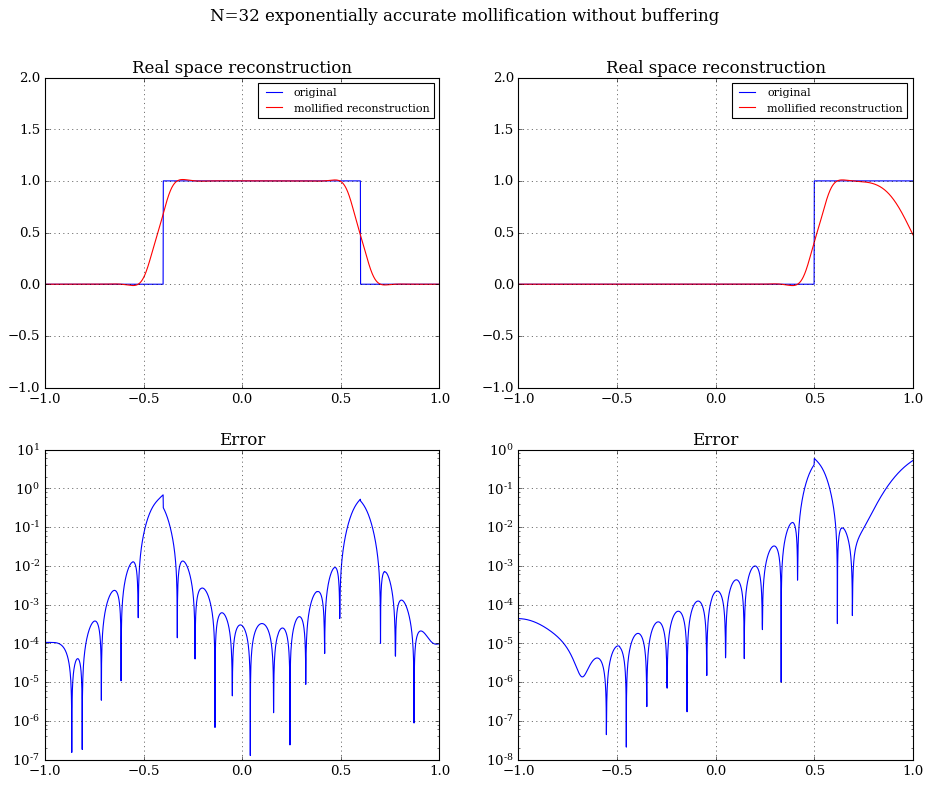

In [23]:
fig, axarr = plt.subplots(2,2, figsize=(14,11))
plt.suptitle('N=32 exponentially accurate mollification without buffering', fontsize=15)
axarr[0,0].plot(x, chi1_x, label='original')
axarr[0,0].plot(x, mollified1, 'r',  label='mollified reconstruction')
#axarr[0,0].plot(x, I_N1, label='reconstruction')
axarr[0,1].plot(x, chi2_x, label='original')
axarr[0,1].plot(x, mollified2, 'r', label='mollified reconstruction')
#axarr[0,1].plot(x, I_N2, label='reconstruction')
axarr[1,0].semilogy(x, err1),  axarr[1,1].semilogy(x, err2)
axarr[0,0].set_title('Real space reconstruction')
axarr[0,1].set_title('Real space reconstruction')
axarr[1,0].set_title('Error')
axarr[1,1].set_title('Error')
axarr[0,0].legend(), axarr[0,1].legend()

In [20]:
def MollifyQuadBuffer(theta, c_j, a_n, x):
    
    N = a_n.shape[0]-1
    deltax = 2.0/(len(x)-1)
    
    I_N = lambda y: T.chebval(y, a_n)
    I_Nf = lambda y: I_N(y) if -1 <= y <= 1 else 0
    buff_right = lambda y: I_N(2.0-y) if 1.0<y<1.4 else 0
    buff_left = lambda y: I_N(-(2.0+y)) if -1.4<y<-1.0 else 0
    I_Nnew = lambda y: buff_right(y) + buff_left(y) + I_Nf(y)
    
    add_left = np.arange(-1.4, -1.0, deltax)
    add_right = np.arange(1.0, 1.4, deltax)
    offset = np.hstack((add_left, x, add_right))
    convolution = np.empty(len(offset))    
    
    for idx, off_x in enumerate(offset):
        c_jx = c_j - off_x
        dx = lambda y: sqrt(theta*N*min(abs(y-c) for c in c_jx))
        var = lambda y: N/(2*theta*dx(y))
        p_N = lambda y: (theta**2)*dx(y)*N
        j_max = int(np.amax(np.frompyfunc(p_N,1,1)(x)))
        h_j = np.zeros(2*(j_max+1))
    
        for j in range(j_max+1):
            h_j[2*j] = ((-1)**j)/((4**j)*factorial(j))
    
        hermite = lambda y: H.hermeval(sqrt(var(y))*y, h_j)
        expon = lambda y: (1./sqrt(theta*N*dx(y)))*exp(-var(y)*(y**2))
        phi = lambda y: hermite(y)*expon(y)
        phif = lambda y: phi(y-off_x)
        norm = quad(phi, -1.0, 1.0)[0]
        
        convfunc = lambda y: (phif(y) * I_Nnew(y))
        convolution[idx] = (1/norm)*quad(convfunc, -1.4, 1.4)[0]
    
    convolution = convolution[len(add_left):-(len(add_right))]
    
    return convolution

In [21]:
buffmollified1 = MollifyQuadBuffer(theta, c_j1, a_n1, x)
buffmollified2 = MollifyQuadBuffer(theta, c_j2, a_n2, x)

In [22]:
bufferr1 = absolute(buffmollified1 - chi1_x)
bufferr2 = absolute(buffmollified2 - chi2_x)

(<matplotlib.legend.Legend at 0x1180bbd10>,
 <matplotlib.legend.Legend at 0x118040c90>)

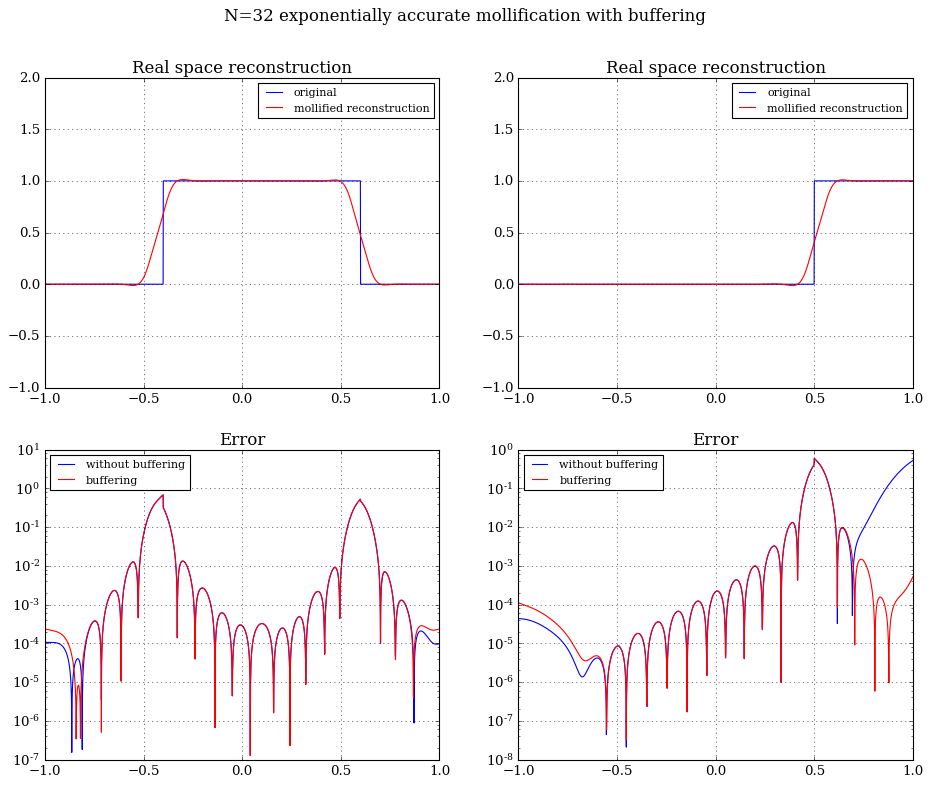

In [27]:
fig, axarr = plt.subplots(2,2, figsize=(14,11))
plt.suptitle('N=32 exponentially accurate mollification with buffering', fontsize=15)
axarr[0,0].plot(x, chi1_x, label='original')
axarr[0,0].plot(x, buffmollified1, 'r',  label='mollified reconstruction')
#axarr[0,0].plot(x, I_N1, label='reconstruction')
axarr[0,1].plot(x, chi2_x, label='original')
axarr[0,1].plot(x, buffmollified2, 'r', label='mollified reconstruction')
#axarr[0,1].plot(x, I_N2, label='reconstruction')
axarr[1,0].semilogy(x, err1, label='without buffering'), axarr[1,0].semilogy(x, bufferr1, 'r', label='buffering')
axarr[1,1].semilogy(x, err2, label='without buffering'), axarr[1,1].semilogy(x, bufferr2, 'r', label='buffering')
axarr[0,0].set_title('Real space reconstruction')
axarr[0,1].set_title('Real space reconstruction')
axarr[1,0].set_title('Error')
axarr[1,1].set_title('Error')
axarr[0,0].legend(), axarr[0,1].legend(), axarr[1,0].legend(loc='upper left'), axarr[1,1].legend(loc='upper left')

# Increasing N behaviour testing

In [28]:
N_val = np.array([40, 48, 64, 72, 100])
err_N = np.empty((2*len(N_val), len(x)))
repr_N = np.empty((2*len(N_val), len(x)))

for idx, N in enumerate(N_val):
    c2s, s2c = Vandermonde(N)
    modalD = ModalD(c2s)
    a_n1 = Decompose(chi1, c2s)
    I_N1 = T.chebval(x, a_n1)
    c_j1 = LocateEdges(a_n1, x, modalD)
    
    a_n2 = Decompose(chi2, c2s)
    I_N2 = T.chebval(x, a_n2)
    c_j2 = LocateEdges(a_n2, x, modalD)
    
    repr_N[2*idx,:] = MollifyQuadBuffer(theta, c_j1, a_n1, x)
    repr_N[(2*idx)+1,:] = MollifyQuadBuffer(theta, c_j2, a_n2, x)
    
    err_N[2*idx,:] = absolute(repr_N[2*idx,:] - chi1_x)
    err_N[(2*idx)+1,:] = absolute(repr_N[(2*idx)+1,:] - chi2_x)

(<matplotlib.legend.Legend at 0x11b1e1090>,
 <matplotlib.legend.Legend at 0x119fb2ad0>)

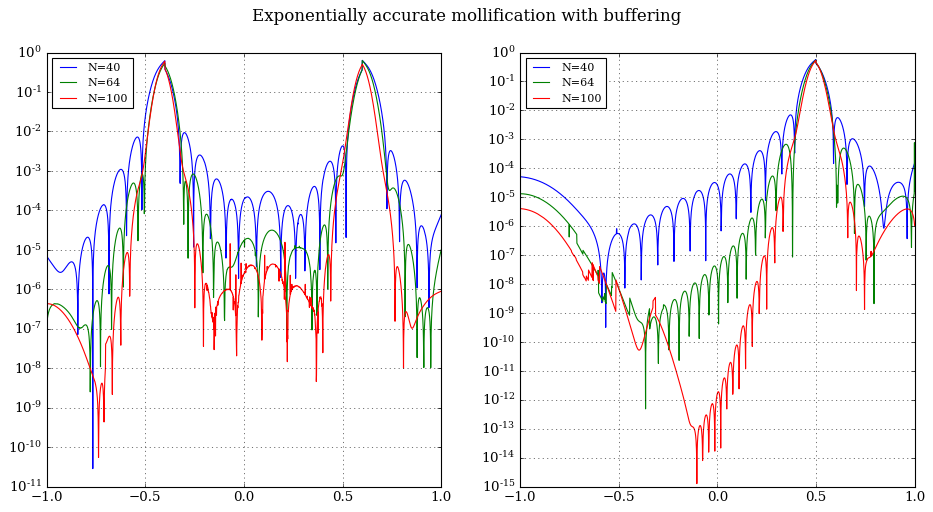

In [32]:
fig, axarr = plt.subplots(1,2, figsize=(14,7))
plt.suptitle('Exponentially accurate mollification with buffering', fontsize=15)
axarr[0].semilogy(x, err_N[0,:], label='N=40'), axarr[1].semilogy(x, err_N[1,:], label='N=40')
#axarr[0].semilogy(x, err_N[2,:], label='N=48'), axarr[1].semilogy(x, err_N[3,:], label='N=48')
axarr[0].semilogy(x, err_N[4,:], label='N=64'), axarr[1].semilogy(x, err_N[5,:], label='N=64')
#axarr[0].semilogy(x, err_N[6,:], label='N=72'), axarr[1].semilogy(x, err_N[7,:], label='N=72')
axarr[0].semilogy(x, err_N[8,:], label='N=100'), axarr[1].semilogy(x, err_N[9,:], label='N=100')
axarr[0].legend(loc='upper left'), axarr[1].legend(loc='upper left')

In [39]:
def MollifyQuadBuffer2(theta, c_j, a_n, x):
    
    N = a_n.shape[0]-1
    deltax = 2.0/(len(x)-1)
    
    I_N = lambda y: T.chebval(y, a_n)
    I_Nf = lambda y: I_N(y) if -1 <= y <= 1 else 0
    buff_right = lambda y: I_N(2.0-y) if 1.0<y<1.4 else 0
    buff_left = lambda y: I_N(-(2.0+y)) if -1.4<y<-1.0 else 0
    I_Nnew = lambda y: buff_right(y) + buff_left(y) + I_Nf(y)
    
    add_left = np.arange(-1.4, -1.0, deltax)
    add_right = np.arange(1.0, 1.4, deltax)
    offset = np.hstack((add_left, x, add_right))
    convolution = np.empty(len(offset))    
    
    for idx, off_x in enumerate(offset):
        c_jx = c_j - off_x
        dx = lambda y: sqrt(theta*N*min(abs(y-c) for c in c_jx))
        var = lambda y: N/(2*theta*dx(y))
        p_N = lambda y: (theta**2)*dx(y)*N
        j_max = int(np.amax(np.frompyfunc(p_N,1,1)(x)))
        h_j = np.zeros(2*(j_max+1))
    
        for j in range(j_max+1):
            h_j[2*j] = ((-1)**j)/((4**j)*factorial(j))
    
        hermite = lambda y: H.hermeval(sqrt(var(y))*y, h_j)
        expon = lambda y: (1./sqrt(theta*N*dx(y)))*exp(-var(y)*(y**2))
        phi = lambda y: hermite(y)*expon(y)
        phif = lambda y: phi(y-off_x)
        norm = quad(phi, -1.4, 1.4)[0]
        
        convfunc = lambda y: (phif(y) * I_Nnew(y))
        convolution[idx] = (1/norm)*quad(convfunc, -1.4, 1.4)[0]
    
    convolution = convolution[len(add_left):-(len(add_right))]
    
    return convolution

In [40]:
err_N2 = np.empty((2*len(N_val), len(x)))
repr_N2 = np.empty((2*len(N_val), len(x)))

for idx, N in enumerate(N_val):
    c2s, s2c = Vandermonde(N)
    modalD = ModalD(c2s)
    a_n1 = Decompose(chi1, c2s)
    I_N1 = T.chebval(x, a_n1)
    c_j1 = LocateEdges(a_n1, x, modalD)
    
    a_n2 = Decompose(chi2, c2s)
    I_N2 = T.chebval(x, a_n2)
    c_j2 = LocateEdges(a_n2, x, modalD)
    
    repr_N2[2*idx,:] = MollifyQuadBuffer2(theta, c_j1, a_n1, x)
    repr_N2[(2*idx)+1,:] = MollifyQuadBuffer2(theta, c_j2, a_n2, x)
    
    err_N2[2*idx,:] = absolute(repr_N2[2*idx,:] - chi1_x)
    err_N2[(2*idx)+1,:] = absolute(repr_N2[(2*idx)+1,:] - chi2_x)

(<matplotlib.legend.Legend at 0x11c5acc90>,
 <matplotlib.legend.Legend at 0x11c155690>)

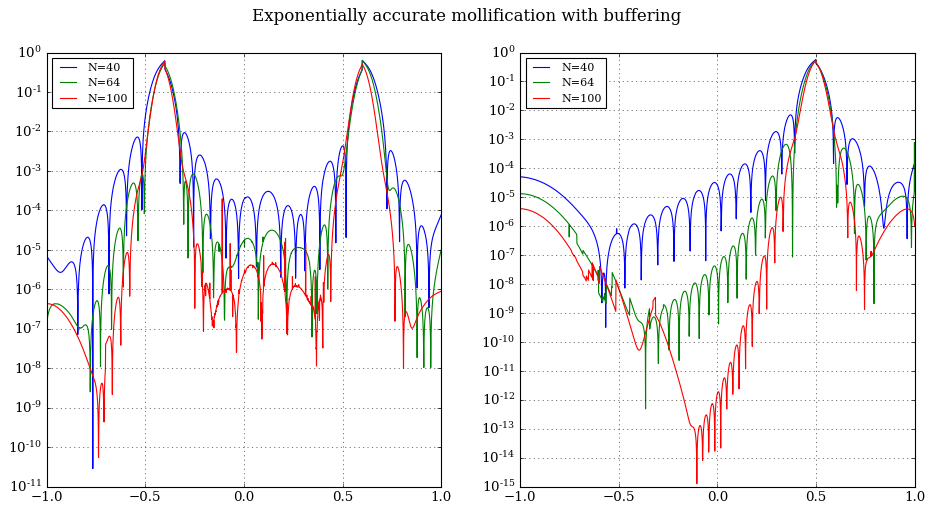

In [42]:
fig, axarr = plt.subplots(1,2, figsize=(14,7))
plt.suptitle('Exponentially accurate mollification with buffering', fontsize=15)
axarr[0].semilogy(x, err_N2[0,:], label='N=40'), axarr[1].semilogy(x, err_N2[1,:], label='N=40')
#axarr[0].semilogy(x, err_N[2,:], label='N=48'), axarr[1].semilogy(x, err_N[3,:], label='N=48')
axarr[0].semilogy(x, err_N2[4,:], label='N=64'), axarr[1].semilogy(x, err_N2[5,:], label='N=64')
#axarr[0].semilogy(x, err_N[6,:], label='N=72'), axarr[1].semilogy(x, err_N[7,:], label='N=72')
axarr[0].semilogy(x, err_N2[8,:], label='N=100'), axarr[1].semilogy(x, err_N2[9,:], label='N=100')
axarr[0].legend(loc='upper left'), axarr[1].legend(loc='upper left')